In [1]:
%matplotlib inline

In [2]:
from matplotlib.pylab import *

In [3]:
# repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
# style.use("results/style_sheet.mplstyle")

rc('figure', figsize=(8, 4))
rc('savefig', bbox='tight')
plt.rcParams.update({'font.size': 16})

import numpy as np
import torch
import torch.nn as nn
from models import resnet18_narrow as resnet18
from utils import get_loader
from utils.train_utils import AverageMeter, accuracy
import argparse
from sklearn.model_selection import ParameterGrid
import pickle
from tqdm import tqdm 
import copy
import glob
import numpy as np
import scipy
import copy

In [13]:
all_measures = ["eps_flat", "pac_bayes", "fro_norm", "fim", "local_entropy_grad_norm", "shannon_entropy", "eig_trace", "low_pass"]
labels = ["$\epsilon$ sharpness", "Pac Bayes", "$||H||_{F}$", "Fisher norm", "Local entropy", "Classical Entropy", "Trace", "Low pass filter"]

gen_gap = np.zeros((20, 2)) # noise x seed 
sharpness = np.zeros((len(all_measures), 20, 2)) # measures x noise x seed 

for k in range(2):
    for j in range(20):
        fol = f"checkpoints/cifar10_noisy/resnet_data_noise_{j*2 / 10}/run_ms_{k}/measures.pkl"
        with open(fol, 'rb') as f:
            mtr = pickle.load(f)    
        gen_gap[j,k-1] = mtr["train_acc"] - mtr["val_acc"]
        for i,meas in enumerate(all_measures, 0):
                try:sharpness[i,j,k-1] = mtr[meas]
                except: print(fol, meas)

sharpness_mean = np.mean(sharpness, 2)
sharpness_std = np.std(sharpness, 2)
sharpness_mean = sharpness_mean - np.min(sharpness_mean, 1).reshape(-1,1)
sharpness_mean = sharpness_mean / np.max(sharpness_mean, 1).reshape(-1,1)
sharpness = sharpness_mean

gen_gap = np.mean(gen_gap, 1)

eps_flat & pac_bayes & fro_norm & fim & local_entropy_grad_norm & shannon_entropy & eig_trace & low_pass & 
0.6967 & 0.8496 & 0.9572 & 0.6475 & 0.8340 & 0.6596 & 0.9370 & 0.9374 & 

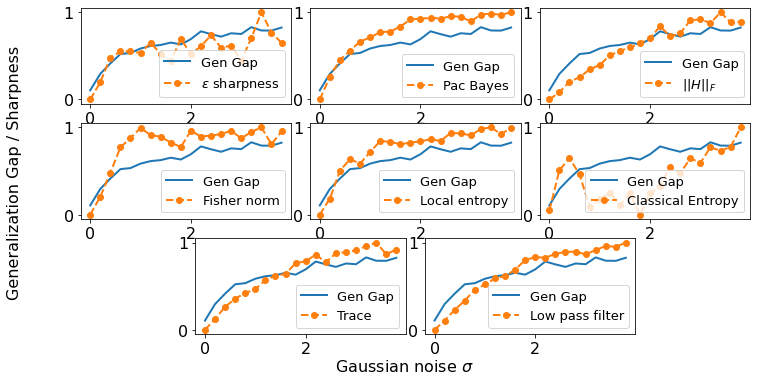

In [14]:
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot2grid(shape=(3,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((3,6), (0,2), colspan=2, sharex=ax1)
ax3 = plt.subplot2grid((3,6), (0,4), colspan=2, sharex=ax1)
ax4 = plt.subplot2grid((3,6), (1,0), colspan=2, sharex=ax1)
ax5 = plt.subplot2grid((3,6), (1,2), colspan=2, sharex=ax1)
ax6 = plt.subplot2grid((3,6), (1,4), colspan=2, sharex=ax1)
ax7 = plt.subplot2grid((3,6), (2,1), colspan=2, sharex=ax1)
ax8 = plt.subplot2grid((3,6), (2,3), colspan=2, sharex=ax1)
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
# ax.plot(widths, gen_gap, linewidth=2, marker='o')
dn = [dn/10 for dn in list(range(0,40,2))]

for i,meas in enumerate(all_measures,0):
    axs[i].plot(dn, gen_gap/100, label=f"Gen Gap",linewidth=2)
    axs[i].plot(dn, sharpness[i,:], label=f"{labels[i]}",linewidth=2, marker='o', linestyle="--")
    axs[i].legend(fontsize=13, loc=4)

fig.text(0.5, 0.04, 'Gaussian noise $\sigma$', ha='center')
fig.text(0.04, 0.5, 'Generalization Gap / Sharpness', va='center', rotation='vertical')
# fig.savefig("results/dn.png")

for i,meas in enumerate(all_measures,0):
    print(f"{meas} & ", end="")
print("")
for i,meas in enumerate(all_measures,0):
    print(f"{scipy.stats.pearsonr(dn, sharpness_mean[i,:])[0]:0.4f} &", end=' ')

In [ ]:
gen_gap